In [291]:
import requests
import urllib.request 
from urllib.request import urlopen 
from bs4 import BeautifulSoup
import re
import json
import pandas as pd
import numpy as np
from numpy.random import randint 
from datetime import date
import datetime as dt
import os 
import glob
import itertools
import operator

In [290]:
import gc
gc.get_count()
gc.collect()
gc.get_count()

(39, 0, 0)

In [292]:
rootpage = 'https://www.rottentomatoes.com/sitemap_' 
end = '.xml'
today = date.today()

def getLinks(pageUrl):
    global pages 
    for sitemap_page in range(0, 25): 
        pages = set() 
        html = urlopen(rootpage+str(sitemap_page)+end)
        bsObj = BeautifulSoup(html)
        
        for link in bsObj.findAll('loc'):
            replacers = ['trailers/', 'pictures/']
            link = str(link).replace('</loc>', '').split('.com')
            
            if link[1] not in pages: 
                pages.add(link[1])
    
        pages = pd.DataFrame(pages, columns=['links'])
        pages.to_csv(r'/Users/mimiyufanyou/Documents/GitHub/rotten_movies/data/movie_links/links_'+str(today)+'_'+str(sitemap_page)+'.csv', sep=',')
        
        print('saved to csv:','links_'+str(today)+'_'+str(sitemap_page)+'.csv', dt.datetime.now())

getLinks('')
        

saved to csv: links_2019-11-21_0.csv 2019-11-21 16:21:28.714431
saved to csv: links_2019-11-21_1.csv 2019-11-21 16:21:31.861701
saved to csv: links_2019-11-21_2.csv 2019-11-21 16:21:34.730917
saved to csv: links_2019-11-21_3.csv 2019-11-21 16:21:36.708482
saved to csv: links_2019-11-21_4.csv 2019-11-21 16:21:39.002903
saved to csv: links_2019-11-21_5.csv 2019-11-21 16:21:41.299001
saved to csv: links_2019-11-21_6.csv 2019-11-21 16:21:43.607177
saved to csv: links_2019-11-21_7.csv 2019-11-21 16:21:45.420458
saved to csv: links_2019-11-21_8.csv 2019-11-21 16:21:47.162921
saved to csv: links_2019-11-21_9.csv 2019-11-21 16:21:49.032116
saved to csv: links_2019-11-21_10.csv 2019-11-21 16:21:50.599177
saved to csv: links_2019-11-21_11.csv 2019-11-21 16:21:52.330727
saved to csv: links_2019-11-21_12.csv 2019-11-21 16:21:54.196291
saved to csv: links_2019-11-21_13.csv 2019-11-21 16:21:55.880003
saved to csv: links_2019-11-21_14.csv 2019-11-21 16:21:57.534307
saved to csv: links_2019-11-21_15.c

In [293]:
filepath = r'/Users/mimiyufanyou/Documents/GitHub/rotten_movies/data/movie_links/*.csv'
df_links = pd.concat([pd.read_csv(f) for f in glob.glob(filepath)], ignore_index = True)
df_links = list(df_links['links'])

In [294]:
trimmed_links = set()

for links in df_links:
    links = links.replace('/pictures/', '').replace('/trailers/', '') 
    trimmed_links.add(links)

df_links = pd.DataFrame(trimmed_links, columns=['movie'])

In [296]:
df_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54075 entries, 0 to 54074
Data columns (total 1 columns):
movie    54075 non-null object
dtypes: object(1)
memory usage: 422.6+ KB


In [297]:
baseurl = 'https://www.rottentomatoes.com'
listlength = len(trimmed_links)
movie_df = pd.DataFrame(columns=['url', 'title', 'genre', 'cag_rating', 'cag_release', 'tomatoScore', 'popcornScore'])
today = date.today()

def getScores(link):
    try: 
        siteurl = urlopen(baseurl+link)

        bsObj = BeautifulSoup(siteurl)
        
        movie_title = str(bsObj).split('"name":"')[1].split('"')[0]
        #print(movie_title, dt.datetime.now())
        
        cag_rating = str(bsObj).split('"contentRating":"')[1].split('"')[0]
        #print(cag_rating, dt.datetime.now())
        
        genre = str(bsObj).split('"genre":')[1].split('}')[0]
        #print(genre, dt.datetime.now())
        
        cag_release = str(bsObj).split('"cag[release]":"')[1].split('"')[0]
        #print(cag_release, dt.datetime.now())

        tomatoScore = str(bsObj).split('ratingValue":')[1].split(',"')[0]
        #print(tomatoScore, dt.datetime.now())

        ems_id = str(bsObj).split('emsId":"')[1].split('"')[0]
        ems_req_url = f'https://www.rottentomatoes.com/napi/audienceScore/{ems_id}'
        #print(ems_id, dt.datetime.now())
        
        ems_response = requests.get(ems_req_url)
        #print(ems_response, dt.datetime.now())
        ems_soup = BeautifulSoup(ems_response.text, 'html.parser')
        ems_text_response = ems_response.text
        #print(dt.datetime.now())
        json_ems = json.loads(ems_text_response)
        popcornScore = json_ems['audienceScoreAll']['score']
        #print(popcornScore, dt.datetime.now())

        movie_df.loc[link] = [link, movie_title, genre, cag_rating, cag_release, tomatoScore, popcornScore]
        
    except: 
        pass

def scrape_movie_batches(start,finish): 
    ts = time()
    for batch in range(start,finish):
        for link in df_links.iloc[batch]: 
            movie_name = df_links.iloc[batch][0]
            getScores(movie_name)
            
    logging.info('Took %s', time() - ts)
    movie_df.to_csv(r'/Users/mimiyufanyou/Documents/GitHub/rotten_movies/data/movie_scores/scores_'+str(today)+'_'+str(batch)+'.csv', sep=',')
    print('saved to csv:','scores_'+str(today)+'_movieids'+str(start)+'_'+str(finish)+'.csv', dt.datetime.now())

In [298]:
import logging 
import os 
import threading
from concurrent.futures import ThreadPoolExecutor 
from functools import partial 
from time import time 

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [317]:
def group(lst, n):
  for i in range(0, len(lst), n):
    val = lst[i:i+n]
    if len(val) == n:
      yield tuple(val)
    
queue = []

for x in range(400, 5000, 250):
    queue.append(x)

tuples = list(group(queue, 2))

tuples

[(400, 650),
 (900, 1150),
 (1400, 1650),
 (1900, 2150),
 (2400, 2650),
 (2900, 3150),
 (3400, 3650),
 (3900, 4150),
 (4400, 4650)]

In [318]:
import threading
  
if __name__ == "__main__": 
    # creating thread 
    for i in tuples: 
        t = threading.Thread(target=scrape_movie_batches, args=i) 
        t.start()
  
    # both threads completely executed 
    print("Done!") 

Done!


2019-11-21 17:32:10,624 - root - INFO - Took 1443.738403081894


saved to csv: scores_2019-11-21_movieids4400_4650.csv 2019-11-21 17:32:10.832032


2019-11-21 17:32:18,417 - root - INFO - Took 1451.5690212249756


saved to csv: scores_2019-11-21_movieids2900_3150.csv 2019-11-21 17:32:18.641123


2019-11-21 17:32:43,258 - root - INFO - Took 1476.4817819595337


saved to csv: scores_2019-11-21_movieids900_1150.csv 2019-11-21 17:32:43.321665


2019-11-21 17:32:47,812 - root - INFO - Took 1481.0131669044495


saved to csv: scores_2019-11-21_movieids1400_1650.csv 2019-11-21 17:32:47.841438


2019-11-21 17:32:48,076 - root - INFO - Took 1481.2020151615143


saved to csv: scores_2019-11-21_movieids3900_4150.csv 2019-11-21 17:32:48.105115


2019-11-21 17:32:52,703 - root - INFO - Took 1485.951252937317


saved to csv: scores_2019-11-21_movieids400_650.csv 2019-11-21 17:32:52.751952


2019-11-21 17:33:01,125 - root - INFO - Took 1494.2647218704224


saved to csv: scores_2019-11-21_movieids3400_3650.csv 2019-11-21 17:33:01.143519


2019-11-21 17:33:03,941 - root - INFO - Took 1497.1058089733124


saved to csv: scores_2019-11-21_movieids2400_2650.csv 2019-11-21 17:33:03.974706


2019-11-21 17:33:09,530 - root - INFO - Took 1502.7115161418915


saved to csv: scores_2019-11-21_movieids1900_2150.csv 2019-11-21 17:33:09.554407


In [319]:
filepath = r'/Users/mimiyufanyou/Documents/GitHub/rotten_movies/data/movie_scores/*.csv'
df_scores = pd.concat([pd.read_csv(f) for f in glob.glob(filepath)], ignore_index = True)
today = date.today()

In [320]:
df_scores.columns

Index(['Unnamed: 0', 'url', 'title', 'genre', 'cag_rating', 'cag_release',
       'tomatoScore', 'popcornScore'],
      dtype='object')

In [334]:
df_scores = df_scores[['url', 'title', 'genre', 'cag_rating', 'cag_release', 'tomatoScore', 'popcornScore']]
df_scores['abs_squidScore'] = abs(df_scores['tomatoScore']- df_scores['popcornScore'])

df_final = df_scores[['url', 'title', 'genre', 'cag_rating', 'cag_release', 'tomatoScore', 'popcornScore', 'abs_squidScore']].dropna(how='any')

In [459]:
df_final['tScore_qcut'] = pd.qcut(df_final['tomatoScore'], 5, labels=False)
df_final['pScore_qcut'] = pd.qcut(df_final['popcornScore'], 5, labels=False)

df_final['tScore_rnd'] = df_final['tomatoScore'].apply(lambda x: str(x)[0])
df_final['pScore_rnd'] = df_final['popcornScore'].apply(lambda x: str(x)[0])
df_final['sScore_rnd'] = df_final['abs_squidScore'].apply(lambda x: str(x)[0])
df_final['sScore'] = df_final['popcornScore']-df_final['tomatoScore']
df_final['sScore_qcut'] = pd.qcut(df_final['sScore'], 5, labels = ['worst', 'bad', 'okay', 'good', 'best'])

df_final['sScore_multi'] = df_final['pScore_qcut']*df_final['tScore_qcut']

In [461]:
df_data = df_final[['title', 'genre', 'cag_rating', 'cag_release', 'sScore', 'sScore_qcut']]

In [337]:
df_final['genre'] = df_final['genre'].apply(lambda x: str(x).replace('[', '').replace(']', '').replace('"', ''))

In [390]:
df_final['genre'] = df_final['genre'].apply(lambda x: str(x).split(',')[0])
#df_final['genre'].apply(lambda x: str(x).split(',')[1])

In [456]:
plotly_scores = df_final[['title', 'sScore']].groupby(by='sScore').count().reset_index()

fig = px.bar(plotly_scores, x='sScore', y='title', width=1000, height=250)
fig.show()

In [349]:
def sScoreOutput(row):
    if row['sScore_multi'] == 16 or row['sScore_multi'] == 25: 
        sScoreOutput = 'universal'
        
    elif row['pScoreqcut'] == 5 and (row['sScore_multi'] == 10 or row['sScore_multi'] == 15 or row['sScore_multi'] == 20): 
        sScoreOutput = 'peanut dominant' 
    
    elif row['sScore_multi'] == 12: 
        sScoreOutput = 'toss up'
        
    elif row['pScore_qcut'] == 4 and (row['sScore_multi'] == 4 or row['sScore_multi'] == 8):
        sScoreOutput = 'peanut dominant - risky'

    elif row['tScore_qcut'] == 4 and (row['sScore_multi'] == 4 or row['sScore_multi'] == 8):
        sScoreOutput = 'critic dominant - risky'
        
    elif row['tScoreqcut'] == 5 and (row['sScore_multi'] == 10 or row['sScore_multi'] == 15 or row['sScore_multi'] == 20): 
        sScoreOutput = 'critic dominant'
        
    elif row['pScore_qcut'] < 4 or row['tScore_qcut'] <4: 
        sScoreOutput = 'no-one should'
        
    return sScoreOutput

In [427]:
df_sScore_output = [] 

for i in range(len(df_final)): 
    df_sScore_output.append(sScoreOutput(df_final.iloc[i]))

In [351]:
df_final['sScore_Output'] = np.asarray(df_sScore_output)

In [352]:
#df_test = df_final.groupby(by='title').count().sort_values(by='url', ascending=False)
df_final = df_final.drop_duplicates()

In [392]:
df_counts = df_final[['genre', 'sScore_Output', 'title']].groupby(by=['genre', 'sScore_Output']).count()
df_counts = df_counts.reset_index()

df_peanuts = df_counts[df_counts['sScore_Output'].isin(['peanut dominant - risky'])]
df_critics = df_counts[df_counts['sScore_Output'].isin(['critic dominant - risky'])]

In [420]:
df_ratings = df_final[['cag_release', 'sScore_Output', 'title']].groupby(by=['cag_release', 'sScore_Output']).count() 
df_ratings = df_ratings.reset_index()

In [457]:
import plotly.express as px 

fig = px.bar(df_ratings, x='cag_release', y='title', color='sScore_Output', height=250, width=1000)
fig.show()

In [218]:
NumX, NumY = 5,5

Matrix = np.zeros((NumY, NumX))

for i in range(NumY):
    for j in range(NumX):
        Matrix[i,j] = (i+1)*(j+1)
        
print(Matrix)

[[ 1.  2.  3.  4.  5.]
 [ 2.  4.  6.  8. 10.]
 [ 3.  6.  9. 12. 15.]
 [ 4.  8. 12. 16. 20.]
 [ 5. 10. 15. 20. 25.]]


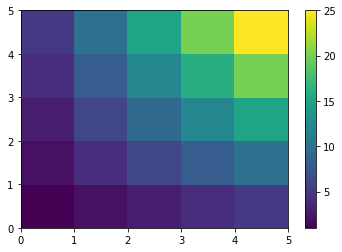

In [101]:
import numpy as np; np.random.seed(1) 
import matplotlib.pyplot as plt

NumX, NumY = 6,6

Matrix = np.zeros((NumY, NumX))

for i in range(NumY):
    for j in range(NumX):
        Matrix[i,j] = (i+1)*(j+1)

xi = np.arange(0, NumX)
yi = np.arange(0, NumY)
X, Y = np.meshgrid(xi, yi)

plt.pcolormesh(X, Y, Matrix)
plt.colorbar()
plt.show()

In [463]:
df_final.to_csv(r'/Users/mimiyufanyou/Documents/GitHub/rotten_movies/data/movie_final/final'+str(today)+'.csv', sep=',', index_label='id')

df_data.to_csv(r'/Users/mimiyufanyou/Documents/GitHub/rotten_movies/data/movie_data/data'+str(today)+'.csv', sep=',', index_label='id')

In [464]:
filepath = r'/Users/mimiyufanyou/Documents/GitHub/rotten_movies/data/movie_final/*.csv'
df_final = pd.concat([pd.read_csv(f) for f in glob.glob(filepath)], ignore_index = True)

filepath = r'/Users/mimiyufanyou/Documents/GitHub/rotten_movies/data/movie_data/*.csv'
df_data = pd.concat([pd.read_csv(f) for f in glob.glob(filepath)], ignore_index = True)